### LSTMの実装

In [1]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
        
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

### TimeLSTMの実装

In [2]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0
        
        grads = [0, 0, 0] 
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            self.dh = dh
            return dxs
        
    def set_state(self, h, c=None):
        self.h, self.c = h, c
        
    def reset_state(self):
        self.h, self.c = None, None

### LSTMを使った言語モデル

In [3]:
from common.time_layers import *
import pickle

------------------------------------------------------------
                       GPU Mode (cupy)
------------------------------------------------------------



In [4]:
class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
        
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
            
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

In [5]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

In [6]:
batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

In [7]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

In [8]:
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 10000.57
| epoch 1 |  iter 21 / 1327 | time 3[s] | perplexity 2692.27
| epoch 1 |  iter 41 / 1327 | time 6[s] | perplexity 1252.73
| epoch 1 |  iter 61 / 1327 | time 9[s] | perplexity 980.69
| epoch 1 |  iter 81 / 1327 | time 12[s] | perplexity 789.74
| epoch 1 |  iter 101 / 1327 | time 15[s] | perplexity 652.47
| epoch 1 |  iter 121 / 1327 | time 18[s] | perplexity 639.44
| epoch 1 |  iter 141 / 1327 | time 21[s] | perplexity 597.98
| epoch 1 |  iter 161 / 1327 | time 24[s] | perplexity 562.75
| epoch 1 |  iter 181 / 1327 | time 27[s] | perplexity 593.69
| epoch 1 |  iter 201 / 1327 | time 31[s] | perplexity 488.02
| epoch 1 |  iter 221 / 1327 | time 34[s] | perplexity 490.34
| epoch 1 |  iter 241 / 1327 | time 37[s] | perplexity 446.82
| epoch 1 |  iter 261 / 1327 | time 40[s] | perplexity 466.34
| epoch 1 |  iter 281 / 1327 | time 43[s] | perplexity 448.58
| epoch 1 |  iter 301 / 1327 | time 46[s] | perplexity 389.05
| epoch 1 |  i

| epoch 2 |  iter 1281 / 1327 | time 402[s] | perplexity 122.00
| epoch 2 |  iter 1301 / 1327 | time 405[s] | perplexity 156.69
| epoch 2 |  iter 1321 / 1327 | time 409[s] | perplexity 153.41
| epoch 3 |  iter 1 / 1327 | time 410[s] | perplexity 162.60
| epoch 3 |  iter 21 / 1327 | time 413[s] | perplexity 143.30
| epoch 3 |  iter 41 / 1327 | time 416[s] | perplexity 134.40
| epoch 3 |  iter 61 / 1327 | time 419[s] | perplexity 125.89
| epoch 3 |  iter 81 / 1327 | time 422[s] | perplexity 116.29
| epoch 3 |  iter 101 / 1327 | time 425[s] | perplexity 105.39
| epoch 3 |  iter 121 / 1327 | time 428[s] | perplexity 115.32
| epoch 3 |  iter 141 / 1327 | time 431[s] | perplexity 125.50
| epoch 3 |  iter 161 / 1327 | time 434[s] | perplexity 141.64
| epoch 3 |  iter 181 / 1327 | time 437[s] | perplexity 149.75
| epoch 3 |  iter 201 / 1327 | time 440[s] | perplexity 141.16
| epoch 3 |  iter 221 / 1327 | time 443[s] | perplexity 139.97
| epoch 3 |  iter 241 / 1327 | time 447[s] | perplexity 13

| epoch 4 |  iter 1221 / 1327 | time 802[s] | perplexity 75.51
| epoch 4 |  iter 1241 / 1327 | time 805[s] | perplexity 91.64
| epoch 4 |  iter 1261 / 1327 | time 808[s] | perplexity 93.20
| epoch 4 |  iter 1281 / 1327 | time 811[s] | perplexity 90.50
| epoch 4 |  iter 1301 / 1327 | time 814[s] | perplexity 109.92
| epoch 4 |  iter 1321 / 1327 | time 817[s] | perplexity 109.30


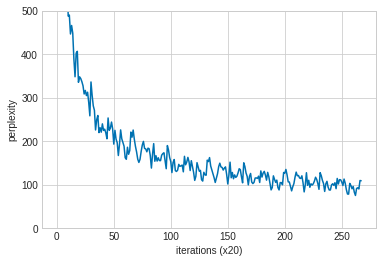

In [9]:
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

In [10]:
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test_perplexity: ', ppl_test)

evaluating perplexity ...
234 / 235
test_perplexity:  136.16937


In [11]:
model.save_params()

### より良いRNNLMの実装

In [12]:
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel

In [13]:
class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)
        ]
        
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs, train_flag=False):
        for layer in self.drop_layers:
            layer.train_flag = train_flag
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts, train_flag=True):
        score = self.predict(xs, train_flag)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [20]:
from common import config
config.GPU = True

In [21]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from better_rnnlm import BetterRnnlm
from dataset import ptb

In [22]:
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

In [23]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

In [24]:
model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

In [25]:
best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size, time_size=time_size, max_grad=max_grad)
    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('test_perplexity: ', ppl)
    
    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr
        model.reset_state()
        print('-' * 50)

| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 10000.64
| epoch 1 |  iter 21 / 1327 | time 6[s] | perplexity 3469.68
| epoch 1 |  iter 41 / 1327 | time 12[s] | perplexity 1748.32
| epoch 1 |  iter 61 / 1327 | time 18[s] | perplexity 1250.91
| epoch 1 |  iter 81 / 1327 | time 25[s] | perplexity 1089.88
| epoch 1 |  iter 101 / 1327 | time 31[s] | perplexity 850.37
| epoch 1 |  iter 121 / 1327 | time 37[s] | perplexity 816.39
| epoch 1 |  iter 141 / 1327 | time 44[s] | perplexity 725.37
| epoch 1 |  iter 161 / 1327 | time 50[s] | perplexity 711.16
| epoch 1 |  iter 181 / 1327 | time 56[s] | perplexity 692.72
| epoch 1 |  iter 201 / 1327 | time 62[s] | perplexity 587.03
| epoch 1 |  iter 221 / 1327 | time 69[s] | perplexity 586.49
| epoch 1 |  iter 241 / 1327 | time 75[s] | perplexity 537.05
| epoch 1 |  iter 261 / 1327 | time 81[s] | perplexity 535.62
| epoch 1 |  iter 281 / 1327 | time 87[s] | perplexity 532.00
| epoch 1 |  iter 301 / 1327 | time 93[s] | perplexity 456.87
| epoch 1 

ValueError: Broadcasting failed

うごごごご....